In [1]:
import time
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Dense, Softmax
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from natsort import natsorted
import matplotlib.pyplot as plt
from glob import glob
import json
from functools import partial
import numpy as np
from cachier import cachier
from tqdm import tqdm
import imageio
from skimage import img_as_float32
import cv2 as cv2
from math import pi, e, sqrt, cos, sin
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [2]:
ztqdm = partial(tqdm, position=0, leave=True)
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')

In [3]:
SIZE = (768, 1024)
NEW_SIZE = (256, 192)
DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'../data/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'../data/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(img_path)), NEW_SIZE) for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(msk_path)), NEW_SIZE) for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])


Loading Masks: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 127.33it/s]


In [4]:
with open(f'../data/corners.json', mode='r') as f:
    DATA_CORNER_NAMES, DATA_CORNERS = json.load(f)
    DATA_CORNERS = np.array(DATA_CORNERS)

In [5]:
def normalise_data(data):
    return np.subtract(data, np.min(data))/ np.subtract(np.max(data), np.min(data))

def show_image(image,cs=False,cmap= None, title=None):
    if cs:
        norm_img = normalise_data(image)
    else:
        norm_img = image
    plt.title(title)
    plt.imshow(norm_img, cmap= cmap)
    plt.xticks([])
    plt.yticks([])

In [6]:
class ImageDataUtils(object):
    
    def train_test_split(self, images, masks, corners, train_size=0.7, validation_size=0.15, test_size=0.15):
        all_indices = np.arange(len(images))
        np.random.shuffle(all_indices)
        train_indices = all_indices[0: int(len(images)* train_size) + 1]
        validate_inidices = all_indices[len(train_indices): len(train_indices) + int(len(images)* validation_size)]
        test_indices = all_indices[len(train_indices)+len(validate_inidices): len(train_indices)+len(validate_inidices)+ int(len(images)* test_size)]

        train_images = np.array([images[i] for i in train_indices])
        train_masks = np.array([masks[i] for i in train_indices])
        train_corners = np.array([corners[i] for i in train_indices])
        
        validate_images = np.array([images[i] for i in validate_inidices])
        validate_masks = np.array([masks[i] for i in validate_inidices])
        validate_corners = np.array([corners[i] for i in validate_inidices])
        
        test_images = np.array([images[i] for i in test_indices])
        test_masks = np.array([masks[i] for i in test_indices])
        test_corners = np.array([corners[i] for i in test_indices])
        
        return train_images, train_masks, train_corners,\
               validate_images, validate_masks, validate_corners,\
               test_images, test_masks, test_corners


    def get_augmented(self, image, mask, gaus=(3, 3)):
        """
        """
        
        # RGB image
        image_list = [normalise_data(image.astype(np.float32))]
        mask_list = [normalise_data(mask.astype(np.float32))]
        
        # Gaussian blurred image
        image_ = cv2.GaussianBlur(image, gaus, 0).astype(np.float32)  
        image_list.append(normalise_data(image_))
        mask_list.append(normalise_data(mask.astype(np.float32)))
        
        # Vertical flip image 
        image_ = cv2.flip(image, 0)
        image_list.append(normalise_data(image_))
        mask_ = cv2.flip(mask, 0)
        mask_list.append(normalise_data(mask_.astype(np.float32)))
        
        # Horizontal flip image
        image_ = cv2.flip(image, 1)
        image_list.append(normalise_data(image_))
        mask_ = cv2.flip(mask, 1)
        mask_list.append(normalise_data(mask_.astype(np.float32)))
        
        return image_list, mask_list

# Train, validation and training split
Split data randomly into sets of 70% training, 15% validation and 15% testing

In [7]:
data_utils = ImageDataUtils()

train_images, train_masks, train_corners, \
validate_images, validate_masks, validate_corners, \
test_images, test_masks, test_corners = data_utils.train_test_split(DATA_IMGS, DATA_MSKS, DATA_CORNERS,
                                                                    train_size=0.7, validation_size=0.15, test_size=0.15)

# Pre-process data:
Create augmented training set (Includes pre-processing of images and masks)

In [8]:
augmented_data = []
augmented_masks = []

for train_image, train_mask in zip(train_images, train_masks):
    image_list, mask_list = data_utils.get_augmented(train_image, train_mask)
    augmented_data += image_list
    augmented_masks += mask_list

Pre-process the validation and test set

In [9]:
validate_data = np.array([normalise_data(validate_image) for validate_image in validate_images])
test_data = np.array([normalise_data(test_image) for test_image in test_images])

## VGG-16

The VGG16 model proposed was tested using the ImageNet data set, which contains over 15 million hand labeled high-resolution images, that belong to around 22-thousand categories. The model was trained for weeks, and pre-trained models are commonly available using deep learning APIs.

In [10]:
vgg16_pretrained = VGG16(include_top=False, weights='imagenet', input_shape=(192,256,3))
vgg16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0     

## The U-Net architecture
U-Net was originally published as a convolutional network for biomedical image segmentation.
The UNet model was named after its U-shape that consists of two paths, which are commonly reffered to in deep learning as the encoder- and
decoder networks. UNet's encoder captures the context of input images, and it contains a symmetric decoder that allows to localization using a technique called upsampling (fractional convolution or transposed convolution.) 
<br><br>
![Unet](resources/Unet.PNG)


### VGG16-U-Net
The idea is to use the pre-trained VGG16 model as the encoder to a U-Net model, and also to construct a symmetric decoder network.

In [15]:
class VGGUnet(object):
    
    def __init__(self, input_shape=(192, 256, 3), num_classes=2):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model(self.input_shape, self.num_classes)
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def summary(self):
        print(self.model.summary())
    
    def _build_model(self, input_shape, num_classes):
        """Builds a UNet model from Keras' pretrained VGG16 model."""
        encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
        
        # Decoder block1, from Encoder output
        encoder_output = encoder.output
        conv_0 = Conv2D(512, 3, activation='relu', padding='same')(encoder_output)
        conv_0_up = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_0)
        
        # Decoder block 1, concat block with encoder block 5
        concat_1 = concatenate([encoder.get_layer('block5_conv3').output, conv_0_up])
        conv_1 = Conv2D(512, 3, activation='relu', padding='same')(concat_1)
        conv_1_up =  Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_1)
        
        # Decoder block 2, concat block with encoder block 4
        concat_2 = concatenate([encoder.get_layer('block4_conv3').output, conv_1_up])
        conv_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_2)
        conv_2_up =  Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_2)
        
        # Decoder block 3, concat block with encoder block 3
        concat_3 = concatenate([encoder.get_layer('block3_conv3').output, conv_2_up])
        conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_3)
        conv_3_up =  Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(conv_3)
        
        # Decoder block 4, concat block with encoder block 2
        concat_4 = concatenate([encoder.get_layer('block2_conv2').output, conv_3_up])
        conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_4)
        conv_4_up =  Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(conv_4)
        
        # Decoder block 5, concat block with encoder block 1
        concat_5 = concatenate([encoder.get_layer('block1_conv2').output, conv_4_up])
        conv_5 = Conv2D(32, 3, activation='relu', padding='same')(concat_5)
        
        outputs = Conv2D(1, 1, activation='sigmoid')(conv_5)
        
        return Model(inputs=encoder.layers[0].input, outputs=outputs)

    def train(self, X, y):
        return self.model.train_on_batch(X, y)[0]
    
    def predict(self, X):
        return self.model.predict(X)

In [16]:
vgg_unet = VGGUnet()

In [17]:
vgg_unet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
_______________________________________________________________________________________

### Training

In [18]:
start_time = time.process_time()
epochs = 5
for epoch in range(epochs):
    loss = 0
    for data, mask in zip(augmented_data, augmented_masks):
        loss += vgg_unet.train(np.expand_dims(data, axis=0), np.expand_dims(mask, axis=0))
    print("[Epoch : " + str(epoch + 1) + "] loss : " + str(loss))
elapsed_time = time.process_time() - start_time
print("Total time : " + str(round(elapsed_time/60,2)) + " mins")

[Epoch : 1] loss : 32.38455509766936
[Epoch : 2] loss : 17.126518251374364
[Epoch : 3] loss : 24.090790258720517
[Epoch : 4] loss : 14.839791372418404
[Epoch : 5] loss : 10.236847840249538
Total time : 113.21 mins


### Validate

In [19]:
def predict_mask(image):
    pred = vgg_unet.predict(np.expand_dims(image, axis=0))
    pred = np.squeeze(pred)
    pred = pred > 0.5
    return pred

In [20]:
pred = predict_mask(validate_images[0])

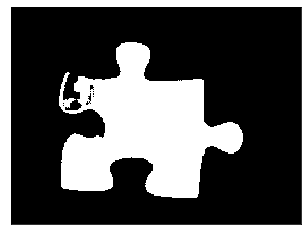

In [21]:
show_image(pred, cmap='gray')